In [ ]:
# SETUP
import sys
import skytree
import skytree.prediction
from skytree import Dataset, TransformSteps
from skytree.prediction import gbt, rdf, rdfr, gbtr

import pandas
import numpy as np
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = 15, 12 

import time
import getpass


server = "localhost"
hostname = 'http://{0}:8080/v1'.format(server);
email = "trial@skytree.net"
password = getpass.getpass()
datadir = "/user/skytree/datasets"


# Authenticate
help(skytree.authenticate)
skytree.authenticate(email, password, hostname)


/opt/skytree/depLibs/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# List all projects
for project in skytree.list_projects():
    print project

name=Income Prediction, id=318278199108811429, description=Predict income based on census data
name=Fraud Detection, id=552140911206770272, description=Detect fraudulent credit card transactions
name=Lead Scoring, id=1460637751992195961, description=Direct marketing to bank deposit prospects
name=Customer Churn, id=6544546745565292258, description=Identify cellular accounts likely to churn


In [3]:
# Next we will create a project
help(skytree.create_project)
project = skytree.create_project("My First SDK Project", "Income prediction dataset")
print project

Help on function create_project in module skytree:

create_project(name, description=None)
    Creates a project. The Skytree Infinity API is organized around projects. A
    project contains the Datasets, Models, and TestResults corresponding to a
    machine learning task. Each project retains a full audit train of how each
    Dataset, Model, or TestResult was created. See the Project class.
    
    name        -> The name for the project. No other project with this name
        should exist.
    description -> Optionally, the description for the project.

name=My First SDK Project, id=3186595281891295585, description=Income prediction dataset


In [4]:
# Next we will create a dataset in the project
help(project.create_dataset)

# create a dataset in the project from a file in HDFS
# If NOT running on a small machine like a laptop you may
# replace "income.data.sample" with "income.data" to run on
# a larger dataset.
IncomeData = project.create_dataset(
    url = 'hdfs://{0}/income.data.sample'.format(datadir), 
    has_header = True, 
    missing_value = "?").ready()

for dataset in project.list_datasets():
    print dataset.summary()

Help on method create_dataset in module skytree:

create_dataset(self, url=None, path=None, name=None, has_header=False, separator=',', missing_value=None, config=None, max_retries=None, wait_time_sec=None) method of skytree.Project instance
    Creates a new Dataset within this project, and returns it. See the
    Python SDK Guide for more information and examples.
    
    url           -> The URL of the datasource file to import. Only one of
        url or path must be specified.
    path          -> The local path of the datasource file to import. Only
        one of url or path must be specified.
    name          -> Optionally, the name for the new Dataset.
    has_header    -> A Boolean specifying whether to treat the first line of
        the datasource file as a header with column names. If False, then
        the columns are given default names.
    separator     -> The character used in the datasource file to separate
        values; eg, ','.
    missing_value -> The charact

In [5]:
# Get information about the dataset, it's columns, statistics, column types etc.
print pandas.DataFrame(IncomeData.columns)

   categorical                                  dictionary_sample  id  \
0        False                                                NaN   1   
1         True  [Private, Self-emp-not-inc, Local-gov, State-g...   2   
2        False                                                NaN   3   
3         True  [HS-grad, Some-college, Bachelors, Masters, As...   4   
4        False                                                NaN   5   
5         True  [Married-civ-spouse, Never-married, Divorced, ...   6   
6         True  [Prof-specialty, Craft-repair, Exec-managerial...   7   
7         True  [Husband, Not-in-family, Own-child, Unmarried,...   8   
8         True  [White, Black, Asian-Pac-Islander, Amer-Indian...   9   
9         True                                     [Male, Female]  10   
10       False                                                NaN  11   
11       False                                                NaN  12   
12       False                                     

In [6]:
# Next, we shall do some basic data preparation

# Add a unique id column
help(Dataset.add_unique_id_column)

# Clamp a continuous value
help(Dataset.clamp_values)

# Normalize a continuous value
help(Dataset.normalize)

Help on method add_unique_id_column in module skytree:

add_unique_id_column(self, column_name, name=None, config=None) unbound skytree.Dataset method
    Returns a new Dataset that is a transformation of this instance, adding
    an ID column as the last column, which serves as a row
    identifier. The new column is guaranteed to be unique but not
    necessarily sequential.
    
    column_name -> The new id column name.
    name        -> Optionally, the name for the new Dataset.
    config      -> Optionally, a DatasetConfig instance.

Help on method clamp_values in module skytree:

clamp_values(self, clamp_column, min_value, max_value, name=None, config=None) unbound skytree.Dataset method
    Returns a new Dataset that is a transformation of this instance,
    substituting a new value in the specified column for values that are out
    of the specified range. The new value will be either the specified
    maximum value or the specified minimum value, depending on whether it
    

In [7]:
# Preparing datasets
# Example shows adding an id column
IncomeWithId = IncomeData.add_unique_id_column("id").ready()

# Apply multiple transform steps together
ts = TransformSteps()
ts.add_clamp_values('age', min_value = 21, max_value = 60)
ts.add_normalize('Unit', normalization_column = 'fnlwgt')
IncomeTransformed = IncomeWithId.apply_transform_steps(ts).ready()

IncomeTraining, IncomeTest = IncomeTransformed.split([7,3])

# Set the ID properties and let the datasets go to ready state
IncomeTraining = IncomeTraining.ready().set_as_id('id').ready()
IncomeTest = IncomeTest.ready().set_as_id('id').ready()

In [8]:
print pandas.DataFrame(IncomeTransformed.columns)

   categorical                                  dictionary_sample  id    max  \
0        False                                                NaN   1     60   
1         True  [Private, Self-emp-not-inc, Local-gov, State-g...   2      0   
2        False                                                NaN   3      1   
3         True  [HS-grad, Some-college, Bachelors, Masters, As...   4      0   
4        False                                                NaN   5     16   
5         True  [Married-civ-spouse, Never-married, Divorced, ...   6      0   
6         True  [Prof-specialty, Craft-repair, Exec-managerial...   7      0   
7         True  [Husband, Not-in-family, Own-child, Unmarried,...   8      0   
8         True  [White, Black, Asian-Pac-Islander, Amer-Indian...   9      0   
9         True                                     [Male, Female]  10      0   
10       False                                                NaN  11  99999   
11       False                          

In [9]:
# Now let's do some machine learning
help(skytree.prediction.learn)


Help on function learn in module skytree.prediction:

learn(train_dataset, objective_column, config=None, name=None)
    Builds and returns a Model instance for any supported machine learning
    method.
    
    train_dataset    -> The Dataset instance that contains the labeled training
        data for the model.
    objective_column -> The Dataset column name that will be the target column.
        This is the column that you are attempting to predict. When performing a
        classification problem, this column must be a categorical column with
        two unique values. When performing a regression problem, this column
        must include only numeric values. Finally, the objective_column cannot
        include missing values. An error will result if the specified
        objective_column does not meet this criteria.
    config           -> The model configuration to be used for training the
        Model. This should be an instance of automodel.Config, gbt.Config,
        gbtr.

In [10]:
# Automodel: Skytree Infinity can automatically find the best model for the given target variable

# NOTE: This can take a while depending on the size of the dataset, the model configuration
# and the hardware resources used/allocated. The default configuration below will build 100 
# distinct models and pick the best

# Arguments: The dataset and what is to be predicted (the target)
model = skytree.prediction.learn(IncomeTraining, objective_column = 'yearly-income')

In [11]:
# Loop and refresh the local model's object state and print status
for i in range(0,5):
    model = project.get_model(model.id)
    print model
    print model.status
    time.sleep(15)

# You can also see a model summary()
print model.summary()

updated_at=2015-09-09 14:32:33, id=4892332605905417460, type=classification, method=automodel, status=ETL_INPROGRESS
{u'message': u'In ETL queue', u'code': u'ETL_INPROGRESS'}
updated_at=2015-09-09 14:32:33, id=4892332605905417460, type=classification, method=automodel, status=ETL_INPROGRESS
{u'message': u' In ETL queue', u'code': u'ETL_INPROGRESS'}
updated_at=2015-09-09 14:33:14, id=4892332605905417460, type=classification, method=automodel, status=ML_INPROGRESS
{u'message': u'Train operation in queue', u'code': u'ML_INPROGRESS'}
updated_at=2015-09-09 14:33:14, id=4892332605905417460, type=classification, method=automodel, status=ML_INPROGRESS
{u'message': u'Train operation in queue', u'code': u'ML_INPROGRESS'}
updated_at=2015-09-09 14:33:14, id=4892332605905417460, type=classification, method=automodel, status=ML_INPROGRESS
{u'message': u'Train operation in queue', u'code': u'ML_INPROGRESS'}
-----------------------
id:              4892332605905417460
name:            automodel model 

In [12]:
# Finally wait for model to be ready
model.ready()  # blocking call
print model.summary()


-----------------------
id:              4892332605905417460
name:            automodel model on 2919183584938049285
method:          automodel
created at:      2015-09-09 14:32:33
updated at:      2015-09-09 14:58:35
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 code: READY
-----------------------
train configuration:
{smart_search_iterations}='{100}', {limit_parameters}='{True}', {holdout_ratio}='{0.2}', {classification_objective}='{FSCORE}', {k_for_precision}='{0.1}'
-----------------------
model configuration:
{smart_search}='{False}', {k_for_precision}='{0.1}', {loss_function}='{LOGISTIC}', {num_trees}='{[343]}', {learning_rate}='{[0.13029059533756135]}', {sample_with_replacement}='{False}', {max_splits}='{[12]}', {tree_depth}='{[4]}', {min_node_weight}='{[14.381290840220466]}', {regularization}='{True}', {regularization_bins}='{[250]}', {cardinality_based_dimension_sampling}='{False}', {trim}='{False}', {trim_alpha}='{0.

In [14]:
# Use model to make predictions on the test set
results = model.test(IncomeTest)
# Loop and refresh the results object state and print status
for i in range(0,5):
    results = project.get_result(results.id)
    print results.status
    time.sleep(15)

# Print generalization error to view model accuracy on validation/test dataset
print "\n" + results.ready().summary()

# Download and save predicted probabilities to a local file
probs_file = open("probabilities.csv", "w")
for (id, probability) in results.get_probabilities(): probs_file.write("%s,%f\n"%(id, probability))
probs_file.close()

{u'message': u'In ETL queue', u'code': u'ETL_INPROGRESS'}
{u'message': u'In ETL queue', u'code': u'ETL_INPROGRESS'}
{u'message': u' In ETL queue', u'code': u'ETL_INPROGRESS'}
{u'message': u'Test operation in queue', u'code': u'ML_INPROGRESS'}
{u'message': u'Test operation in queue', u'code': u'ML_INPROGRESS'}

Skytree classification test result
-----------------------
False positive rate: 0.0939152
Precision:           0.718522
Recall:              0.74736
Accuracy:            0.867535
F score:             0.732657
Confusion matrix:    
---
Class -1: Wrong: 693. Right: 6686. Total 7379.
Class  1: Wrong: 598. Right: 1769. Total 2367.
Overall : Wrong: 1291. Right: 8455. Total 9746.
---
Gini:                0.858161
Capture Deviation:   0.0394533
-----------------------


In [28]:
# Now let's do some tuning ourselves and build a few different models
# Start with: GBT - Automatic Grid Search
gbt_config = gbt.Config() 
gbt_config.num_folds = 5
gbt_config.tree_depth = [2,3,4,5]
gbt_config.learning_rate = [0.10,0.20,0.30]
gbt_config.num_trees = 10
print "Model Configuration:\n" + gbt_config.summary() + "\n"

# Training and Auto-Tuning
model = skytree.prediction.learn(IncomeTraining, 'yearly-income', gbt_config, name = "Gbt Grid Search").ready()
print model.summary()

Model Configuration:
{smart_search}='{False}', {num_folds}='{5}', {k_for_precision}='{0.1}', {loss_function}='{LOGISTIC}', {num_trees}='{[10]}', {learning_rate}='{[0.1, 0.2, 0.3]}', {sample_with_replacement}='{True}', {tree_depth}='{[2, 3, 4, 5]}', {regularization}='{True}', {regularization_bins}='{[200]}', {cardinality_based_dimension_sampling}='{False}', {trim}='{False}', {enable_pmml_out}='{False}'

-----------------------
id:              8667033611704136381
name:            Gbt Grid Search
method:          gbt
created at:      2015-09-09 17:51:06
updated at:      2015-09-09 17:52:52
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 code: READY
-----------------------
train configuration:
{smart_search}='{False}', {num_folds}='{5}', {k_for_precision}='{0.1}', {loss_function}='{LOGISTIC}', {num_trees}='{[10]}', {learning_rate}='{[0.1, 0.2, 0.3]}', {sample_with_replacement}='{True}', {tree_depth}='{[2, 3, 4, 5]}', {regularizatio

In [34]:
# Let's look at the tuning results of the grid search
# Let's print the top 6 best results by Classification Accuracy score
print pandas.DataFrame(model.tuning_results).sort(['accuracy'], ascending = False).head(6)

     accuracy  accuracyProbThreshold  captureDeviation  \
119  0.867531               0.493430          0.100483   
118  0.866396               0.489928          0.114172   
117  0.865698               0.467871          0.137002   
116  0.865039               0.448452          0.156212   
109  0.864378               0.452080          0.165559   
115  0.864078               0.440611          0.192182   

     captureDeviationProbThreshold    fScore  fScoreProbThreshold      gini  \
119                       0.338776  0.715160             0.338776  0.835342   
118                       0.357893  0.712425             0.357893  0.833000   
117                       0.337306  0.711899             0.337306  0.831704   
116                       0.326663  0.709871             0.326663  0.829599   
109                       0.346949  0.708615             0.346949  0.828860   
115                       0.323624  0.707094             0.323624  0.827284   

     giniProbThreshold  leafNodes  lear

In [20]:
# Let's Analyze the tuning results of the grid search. 
# Quick matplotlib chart to put a tuning hyperparameter on the x-axis
# a accuracy metric on the y-axis to see relationship between
# accuracy and hyperparameter

def create_tuning_results_chart(model, x_axis_feature, list_column_groups, y_axis_metric):

    pdf = pandas.DataFrame(model.tuning_results)
    legend = []
    
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(pdf.groupby(list_column_groups)))])
    
    for group in pdf.groupby(list_column_groups):
        label = ""
        if len(list_column_groups) > 1:
            for i in range(0, len(list_column_groups)): 
                label = label + list_column_groups[i] + "=" + str(round(group[0][i],1)) + ","
        else:
            label = label + list_column_groups[0] + "=" + str(round(group[0],1)) + ","
        plt.plot(group[1][x_axis_feature], group[1][y_axis_metric], label = label)
    plt.legend(loc='lower right', prop={'size':12})
    plt.ylabel(y_axis_metric)
    plt.xlabel(x_axis_feature)
    title(model.name)
    plt.show()

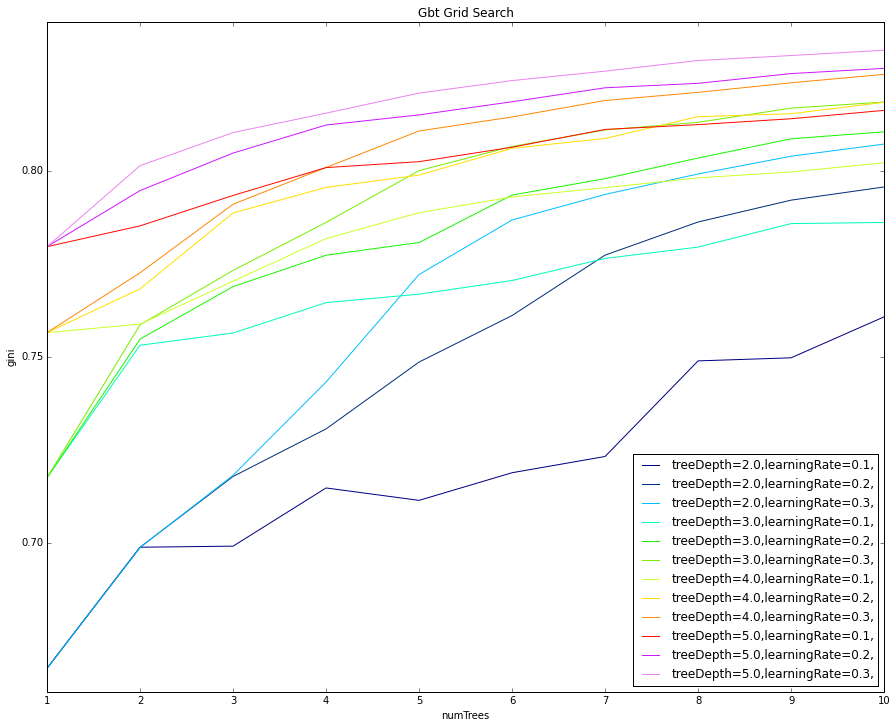

In [21]:
create_tuning_results_chart(model.ready(), "numTrees",  ["treeDepth", "learningRate"], "gini")

In [24]:
# Let's try a random forest
# RDF - Automatic Grid Search
rdf_config = rdf.Config() 
rdf_config.holdout_ratio = 0.2
rdf_config.num_dimensions = [1,2,3,4,5,6]
rdf_config.num_trees = 10
print "Model Configuration:\n" + rdf_config.summary() + "\n"

# Training and Auto-Tuning
model = skytree.prediction.learn(IncomeTraining, 'yearly-income', rdf_config, name = "Rdf Grid Search").ready()
print model.summary()

Model Configuration:
{holdout_ratio}='{0.2}', {k_for_precision}='{0.1}', {num_trees}='{[10]}', {num_dimensions}='{[1, 2, 3, 4, 5, 6]}', {prob_aggregation_method}='{AVERAGE}', {sample_with_replacement}='{True}', {imbalance}='{False}', {impurity_api}='{GINI}', {split_criterion}='{INFORMATION_GAIN_RATIO}', {categorical_selection_method}='{RANDOM_EXACT}', {categorical_random_split_tries}='{10}', {categorical_random_split_threshold}='{4}', {cardinality_based_dimension_sampling}='{False}', {enable_pmml_out}='{False}'

-----------------------
id:              5377280494180663410
name:            Rdf Grid Search
method:          rdf
created at:      2015-09-09 17:02:00
updated at:      2015-09-09 17:03:16
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 code: READY
-----------------------
train configuration:
{holdout_ratio}='{0.2}', {k_for_precision}='{0.1}', {num_trees}='{[10]}', {num_dimensions}='{[1, 2, 3, 4, 5, 6]}', {prob_aggregati

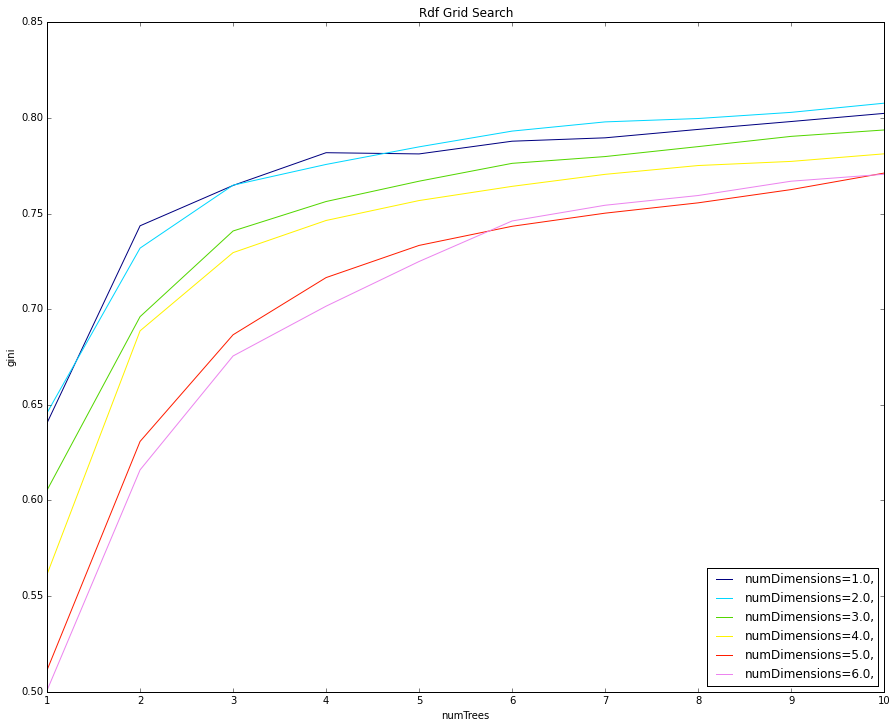

In [25]:
create_tuning_results_chart(model.ready(), "numTrees",  ["numDimensions"], "gini")

In [35]:
# Now let's tune a GBT model with smart search
# Smart Seach GBT - Classification
gbt_config = gbt.Config()
print gbt_config
gbt_config.smart_search_iterations = 30
gbt_config.smart_search = True;
gbt_config.num_trees = None
gbt_config.tree_depth = None
gbt_config.learning_rate = None
gbt_config.holdout_ratio = 0.2
print "Model Configuration:\n" + gbt_config.summary() + "\n"

model = skytree.prediction.learn(IncomeTraining, 'yearly-income', gbt_config, name = "Gbt Smart Search 1").ready()
print model.summary()

{smart_search}='{False}', {k_for_precision}='{0.1}', {loss_function}='{LOGISTIC}', {num_trees}='{[100]}', {learning_rate}='{[0.1]}', {sample_with_replacement}='{True}', {tree_depth}='{[3]}', {regularization}='{True}', {regularization_bins}='{[200]}', {cardinality_based_dimension_sampling}='{False}', {trim}='{False}', {enable_pmml_out}='{False}'
Model Configuration:
{smart_search}='{True}', {smart_search_iterations}='{30}', {holdout_ratio}='{0.2}', {k_for_precision}='{0.1}', {loss_function}='{LOGISTIC}', {sample_with_replacement}='{True}', {regularization}='{True}', {regularization_bins}='{[200]}', {cardinality_based_dimension_sampling}='{False}', {trim}='{False}', {enable_pmml_out}='{False}'

-----------------------
id:              1245702144853375225
name:            Gbt Smart Search 1
method:          gbt
created at:      2015-09-09 17:57:06
updated at:      2015-09-09 18:18:22
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 

In [38]:
# Let's look at the tuning results of the grid search
# Let's print the top 6 best results by Gini score
print pandas.DataFrame(model.tuning_results).sort("gini", ascending = False).head(6)

    accuracy  accuracyProbThreshold  captureDeviation  \
27  0.871220               0.570560          0.093287   
29  0.873396               0.510758          0.057247   
18  0.874483               0.517420          0.074400   
28  0.869915               0.539710          0.101662   
22  0.874701               0.450335          0.073965   
13  0.872961               0.544089          0.088716   

    captureDeviationProbThreshold    fScore  fScoreProbThreshold      gini  \
27                       0.355645  0.726968             0.355645  0.851174   
29                       0.385981  0.729085             0.385981  0.851084   
18                       0.398918  0.734033             0.398918  0.850504   
28                       0.401897  0.726242             0.401897  0.850460   
22                       0.450335  0.734807             0.450335  0.849845   
13                       0.373283  0.728126             0.373283  0.849616   

    giniProbThreshold  leafNodes  learningRate  maxSp

In [39]:
# Now let's build some regression models and compare the
# validation error amongst them
# Smart Seach GBT - Regression
gbtr_config = gbtr.Config()
gbtr_config.smart_search_iterations = 30
gbtr_config.smart_search = True;
gbtr_config.holdout_ratio = 0.3
gbtr_config.num_trees = None
gbtr_config.tree_depth = None
gbtr_config.learning_rate = None
print "Model Configuration:\n" + gbtr_config.summary() + "\n"

model = skytree.prediction.learn(IncomeTraining, 'age', gbtr_config, name = "Gbtr Smart Search Model").ready()
print model.summary()
results = model.test(IncomeTest, name = "Gbtr Smart Search Results").ready()

Model Configuration:
{smart_search}='{True}', {smart_search_iterations}='{30}', {holdout_ratio}='{0.3}', {loss_function}='{LAD}', {sample_with_replacement}='{True}', {regularization}='{True}', {regularization_bins}='{[200]}', {cardinality_based_dimension_sampling}='{False}', {enable_pmml_out}='{False}'

-----------------------
id:              2785998130240522263
name:            Gbtr Smart Search Model
method:          gbtr
created at:      2015-09-09 19:15:22
updated at:      2015-09-09 19:21:52
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 code: READY
-----------------------
train configuration:
{smart_search}='{True}', {smart_search_iterations}='{30}', {holdout_ratio}='{0.3}', {loss_function}='{LAD}', {sample_with_replacement}='{True}', {regularization}='{True}', {regularization_bins}='{[200]}', {cardinality_based_dimension_sampling}='{False}', {enable_pmml_out}='{False}'
-----------------------
model configuration:
{smart

In [53]:
# Helper function to plot true targets vs. predicted target values in regression problems
def plot_true_vs_predicted_regression_plot(dataset, results, target_index, id_index):
    ids = []
    predictions = []
    for p in results.get_targets(): ids.append(p[0]), predictions.append(p[1])
    predicted = pandas.DataFrame(predictions, index = ids, columns = ["target"])
    data = IncomeTest.sample(1000)
    true = pandas.DataFrame({'target': data["data"][target_index]} , index = data["data"][id_index], dtype=float32)
    joined = predicted.join(true, how = "inner", lsuffix = "_predicted")
    #Plot predicted results versus true
    max_a= max(joined["target_predicted"].max(), joined["target"].max())
    min_a= min(joined["target_predicted"].min(), joined["target"].min())
    plt.xlim(min_a,max_a) #Axes are cut to 0 <= distance <= 1 for readability
    plt.ylim(min_a,max_a)
    plt.grid()
    plt.xlabel('True Target')
    plt.ylabel('Predicted Target')
    plt.title(results.name)
    plt.plot([0,100],[0,100],'k-')
    plt.plot(joined["target_predicted"],joined["target"],'go')
    return plt

Skytree regression test result
-----------------------
L1 error:                     67361.4
Relative L1 error:            0.180728
L2 error:                     898.228
Relative L2 error:            0.226382
Mean absolute error:          6.9117
Mean squared error:           82.784
Root mean squared error:      9.09857
Coefficient of determination: 0.458114
-----------------------


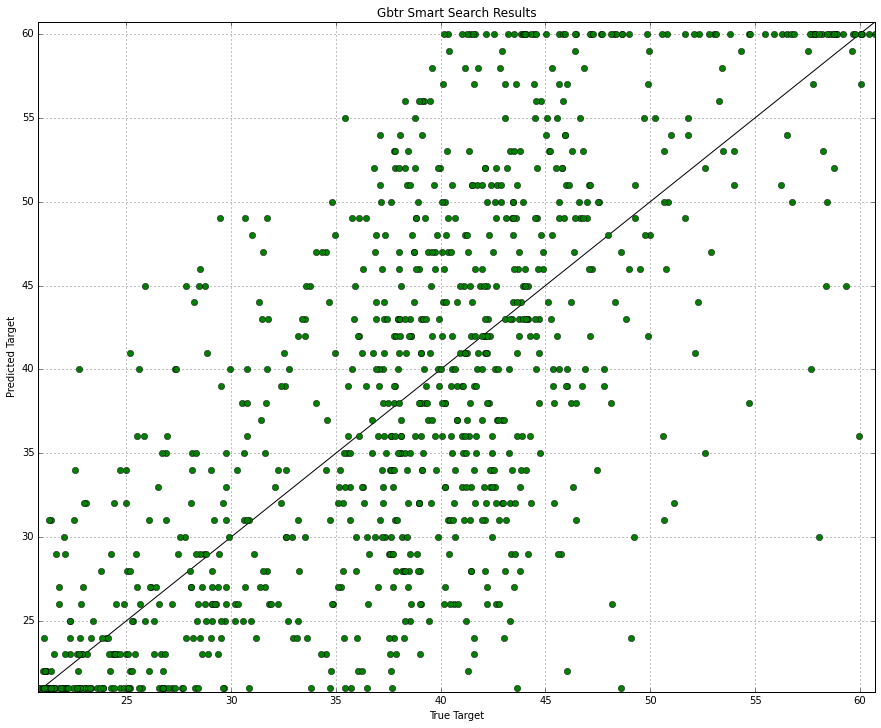

In [56]:
print results.summary()
plt = plot_true_vs_predicted_regression_plot(IncomeTest, results, 0, 15)
plt.show()

In [42]:
# RDF - Regression
rdfr_config = rdfr.Config()
rdfr_config.num_trees = 100
rdfr_config.num_dimensions = [4,6,8,10];
rdfr_config.holdout_ratio = 0.2
print "Model Configuration:\n" + rdfr_config.summary() + "\n"

model = skytree.prediction.learn(IncomeTraining, 'age', rdfr_config, name = "Rdfr Grid Search").ready()
print model.summary()
results = model.test(IncomeTest, name = "Rdfr Grid Search Results").ready()

Model Configuration:
{holdout_ratio}='{0.2}', {num_trees}='{[100]}', {num_dimensions}='{[4, 6, 8, 10]}', {sample_with_replacement}='{True}', {cardinality_based_dimension_sampling}='{False}', {enable_pmml_out}='{False}'

-----------------------
id:              9182787463517706959
name:            Rdfr Grid Search
method:          rdfr
created at:      2015-09-09 19:40:50
updated at:      2015-09-09 19:49:00
dataset id:      2919183584938049285
-----------------------
status:
 message: Model is ready to be used
 code: READY
-----------------------
train configuration:
{holdout_ratio}='{0.2}', {num_trees}='{[100]}', {num_dimensions}='{[4, 6, 8, 10]}', {sample_with_replacement}='{True}', {cardinality_based_dimension_sampling}='{False}', {enable_pmml_out}='{False}'
-----------------------
model configuration:
{num_trees}='{[90]}', {num_dimensions}='{[4]}', {sampling_ratio}='{[-1.0]}', {sample_with_replacement}='{True}', {tree_depth}='{[0]}', {min_node_weight}='{[2.0]}', {cardinality_based_

Skytree regression test result
-----------------------
L1 error:                     69042.9
Relative L1 error:            0.18524
L2 error:                     895.563
Relative L2 error:            0.22571
Mean absolute error:          7.08423
Mean squared error:           82.2935
Root mean squared error:      9.07158
Coefficient of determination: 0.461325
-----------------------


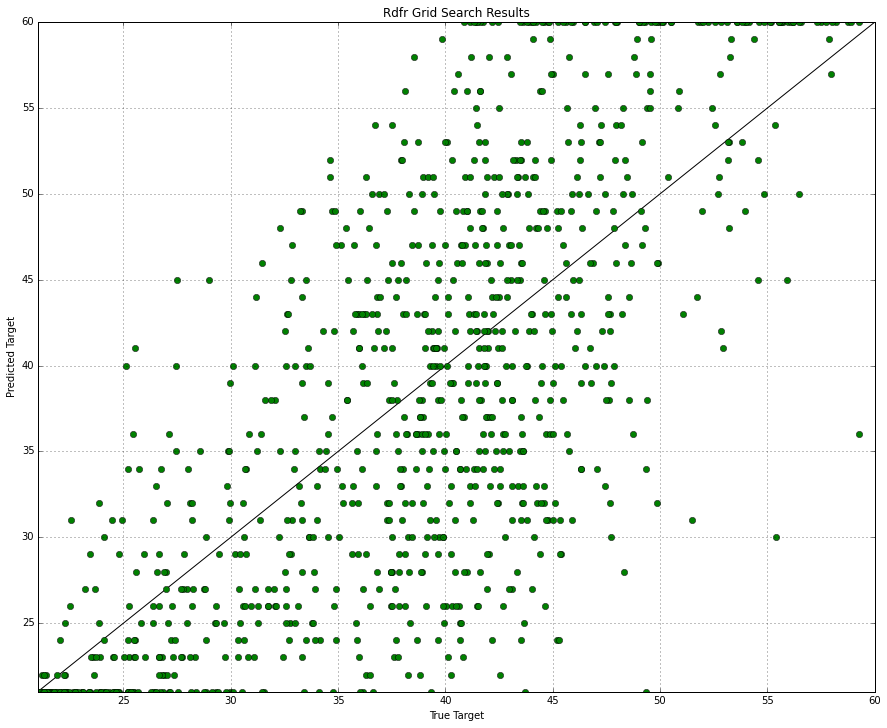

In [58]:
print results.summary()
plt = plot_true_vs_predicted_regression_plot(IncomeTest, results, 0, 15)
plt.show()